## Characterizing a Single-Species Graph
The purpose of this notebook is to characterize the dataset of genes, phenotypes, and annotations for Arabidopsis thaliana specifically. The sources of information include several different resources which are aggregated at differnet points in the analysis, and specified below. We want to figure out what kinds of properties the different graphs have in terms of potential predictive power for untangling pathway interactions or predicting pathway membership of regulatory network clusters. This is done for the purposes of figuring out if the predictions made over text descriptions that do *not* have the corresponding high-quality annotations or characterizations are likely to be useful to biologists.

In [44]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
import sys
import gensim
import os
import warnings
import itertools
from collections import Counter
from inspect import signature

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from scipy.stats import ks_2samp

sys.path.append("../../oats")
from oats.utils.utils import save_to_pickle, load_from_pickle, merge_list_dicts
from oats.utils.utils import function_wrapper, to_hms
from oats.datasets.dataset import Dataset
from oats.datasets.groupings import Groupings
from oats.datasets.string import get_string_protein_links_df
from oats.annotation.ontology import Ontology
from oats.annotation.annotation import write_annotations_to_tsv_file, read_annotations_from_tsv_file
from oats.graphs.pairwise import get_edgelist_with_doc2vec, get_edgelist_with_bagofwords, get_edgelist_with_setofwords
from oats.graphs.pairwise import get_edgelist_with_annotations, merge_edgelists, subset_edgelist_with_ids

warnings.simplefilter('ignore')

### Does the graph based on text similarity recapitulate known protein-protein interactions?
A more in depth description of this question here, what we expected and what we want to know and why we want to know it.

In [2]:
# This dataset is only focused on including all genes mapped to some text information.
dataset = Dataset()
dataset.add_data(pd.read_csv("../data/reshaped_files/ath_tair_gene_text.csv", lineterminator="\n"))
dataset.add_data(pd.read_csv("../data/reshaped_files/all_pppn_gene_textlong_annot.csv", lineterminator="\n"))
dataset.add_data(pd.read_csv("../data/reshaped_files/all_pppn_gene_textshort_annot.csv", lineterminator="\n"))
dataset.filter_by_species(["ath"])
dataset.collapse_by_first_gene_name()
dataset.filter_has_description()
dataset.filter_random_k(100, seed=19824)
dataset.describe()

Number of rows in the dataframe: 100
Number of unique IDs:            100
Number of unique descriptions:   86
Number of unique gene name sets: 100
Number of species represented:   1


In [3]:
# Setup some of the preliminary ontology, embedding, and datset stuff.
doc2vec_model_filename = "../gensim/enwiki_dbow/doc2vec.bin"
doc2vec_model = gensim.models.Doc2Vec.load(doc2vec_model_filename)
descriptions = dataset.get_description_dictionary()
genes = dataset.get_gene_dictionary()

# Construct the graphs based on similarity between the text associated with each gene.
name_to_df_mapping = {}
name_to_df_mapping["doc2vec"] = get_edgelist_with_doc2vec(doc2vec_model, descriptions)
name_to_df_mapping["bagofwords"] = get_edgelist_with_bagofwords(descriptions) 
name_to_df_mapping["setofwords"] = get_edgelist_with_setofwords(descriptions)
df = merge_edgelists(name_to_df_mapping, default_value=0.000)
print(df.head(16))
print(df.shape)

    from  to   doc2vec  bagofwords  setofwords
0      0   0  0.000000    0.000000         0.0
1      0   1  0.518536    0.974048         1.0
2      0   2  0.476540    0.933660         1.0
3      0   3  0.522806    1.000000         1.0
4      0   4  0.556991    0.840248         1.0
5      0   5  0.492572    1.000000         1.0
6      0   6  0.509483    1.000000         1.0
7      0   7  0.501633    0.849093         1.0
8      0   8  0.302197    0.779455         1.0
9      0   9  0.521054    0.920943         1.0
10     0  10  0.398420    1.000000         1.0
11     0  11  0.555490    1.000000         1.0
12     0  12  0.317432    0.785487         1.0
13     0  13  0.529254    1.000000         1.0
14     0  14  0.558438    1.000000         1.0
15     0  15  0.562853    1.000000         1.0
(5050, 5)


In [4]:
string_database_file = "/Users/irbraun/Downloads/3702.protein.links.detailed.v11.0.txt"
ppi_df = get_string_protein_links_df(string_database_file, genes)
df = df.merge(right=ppi_df, how="left", on=["from","to"])
df.fillna(value=0,inplace=True)
print(df.head(10))

   from  to   doc2vec  bagofwords  setofwords  neighborhood  combined_score
0     0   0  0.000000    0.000000         0.0           0.0             0.0
1     0   1  0.518536    0.974048         1.0           0.0             0.0
2     0   2  0.476540    0.933660         1.0           0.0             0.0
3     0   3  0.522806    1.000000         1.0           0.0             0.0
4     0   4  0.556991    0.840248         1.0           0.0             0.0
5     0   5  0.492572    1.000000         1.0           0.0             0.0
6     0   6  0.509483    1.000000         1.0           0.0             0.0
7     0   7  0.501633    0.849093         1.0           0.0             0.0
8     0   8  0.302197    0.779455         1.0           0.0             0.0
9     0   9  0.521054    0.920943         1.0           0.0             0.0


Testing to see if the similarity values generated based on text were able to recapitulate the known protein-protein interactions from the STRING database specifically for Arabdidopsis proteins. Does a distinction need to be made here between whether or not nodes from the graph were not found at all in the STRING database, or whether it was just that
no relevant interaction (to another node in the dataset) occurs? Figure this out.

In [20]:
ppi_pos = df[df["combined_score"] > 0.00]["bagofwords"].values
ppi_neg = df[df["combined_score"] == 0.00]["bagofwords"].values
print(np.average(ppi_pos))
print(np.average(ppi_neg))
print(ks_2samp(ppi_neg,ppi_pos))

0.8343380043871298
0.878261898392364
Ks_2sampResult(statistic=0.28278907273521275, pvalue=0.004315560655747452)


In [50]:
def balance_classes(y_true, y_scores, ratio):
    pos_tuples = [(t,s) for t,s in zip(y_true,y_scores) if t==1]
    neg_tuples = [(t,s) for t,s in zip(y_true,y_scores) if t==0]
    max_pos_samples = len(pos_tuples)
    max_neg_samples = len(pos_tuples)*ratio
    pos_tuples = pos_tuples[:max_pos_samples]
    neg_tuples = neg_tuples[:max_neg_samples]
    pos_tuples.extend(neg_tuples)
    all_tuples = pos_tuples
    y_true = [x[0] for x in all_tuples]
    y_scores = [x[1] for x in all_tuples]
    return(y_true,y_scores)

Text(0.5, 1.0, 'Protein-Protein Precision-Recall Curve: BL=0.01')

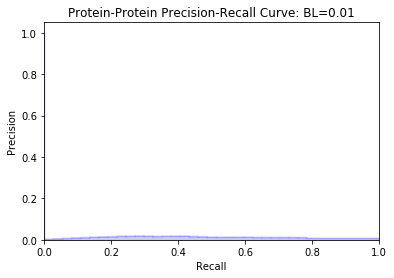

In [74]:
df["new"] = 1-df["bagofwords"]

y_true = np.where(df["combined_score"] > 0.000, 1, 0)
y_scores = df["new"].values

#class_ratio = 2
#y_true,y_scores = balance_classes(y_true,y_scores, class_ratio)

                    
# Generating the precision and recall values from the predicted values and classes.
precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
baseline = Counter(y_true)[1]/len(y_true) 
average_precision = average_precision_score(y_true, y_scores)
area = auc(recall, precision)
auc_to_baseline_auc_ratio = area/baseline
step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

# Formatting the precision and recall plot.
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Protein-Protein Precision-Recall Curve: BL={0:0.2f}'.format(baseline))